In [1]:
# pip install mlxtend

In [2]:
# pip install scikit-learn-extra

In [3]:
import sqlite3
import pandas as pd
import seaborn as sns
import random
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score 
import numpy as np
from sklearn_extra.cluster import KMedoids
from numpy.random import default_rng
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/sklearn_extra/cluster/_commonnn.py:9: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  from distutils.version import LooseVersion


In [4]:
con = sqlite3.connect("accident_data_v1.0.0_2023.db")

In [5]:
cur = con.cursor()

In [6]:
table_list = cur.execute("SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;").fetchall()
table_list = [x[0] for x in table_list]
table_list

['accident', 'casualty', 'lsoa', 'vehicle']

In [7]:
def show_table(table):
    col_info = cur.execute(f"PRAGMA table_info({table})")
    return col_info.fetchall()

def show_attributes(col_info):
    print([x[1] for x in col_info])

In [8]:
for table in table_list:
    print(f"\nTable name : {table}\n")
    col_info = show_table(table)
    show_attributes(col_info)
    print('\n')


Table name : accident

['accident_index', 'accident_year', 'accident_reference', 'location_easting_osgr', 'location_northing_osgr', 'longitude', 'latitude', 'police_force', 'accident_severity', 'number_of_vehicles', 'number_of_casualties', 'date', 'day_of_week', 'time', 'local_authority_district', 'local_authority_ons_district', 'local_authority_highway', 'first_road_class', 'first_road_number', 'road_type', 'speed_limit', 'junction_detail', 'junction_control', 'second_road_class', 'second_road_number', 'pedestrian_crossing_human_control', 'pedestrian_crossing_physical_facilities', 'light_conditions', 'weather_conditions', 'road_surface_conditions', 'special_conditions_at_site', 'carriageway_hazards', 'urban_or_rural_area', 'did_police_officer_attend_scene_of_accident', 'trunk_road_flag', 'lsoa_of_accident_location']



Table name : casualty

['casualty_index', 'accident_index', 'accident_year', 'accident_reference', 'vehicle_reference', 'casualty_reference', 'casualty_class', 'sex_of

In [9]:
for table in table_list:
    print(table, ':', cur.execute(f"SELECT COUNT(*) FROM {table}").fetchall()[0][0])

accident : 461352
casualty : 600332
lsoa : 34378
vehicle : 849091


In [10]:
accident_df = pd.read_sql_query('SELECT * FROM accident', con)
casualty_df = pd.read_sql_query('SELECT * FROM casualty', con)
vehicle_df = pd.read_sql_query('SELECT * FROM vehicle', con)
lsoa_df = pd.read_sql_query('SELECT * FROM lsoa', con) 

In [11]:
accident_df

,accident_index,accident_year,accident_reference,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,...,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location
0,2017010001708,2017,010001708,532920.0,196330.0,-0.080107,51.650061,1,1,2,...,0,4,1,1,0,0,1,1,2,E01001450
1,2017010009342,2017,010009342,526790.0,181970.0,-0.173845,51.522425,1,3,2,...,0,4,1,2,0,0,1,1,2,E01004702
2,2017010009344,2017,010009344,535200.0,181260.0,-0.052969,51.514096,1,3,3,...,0,4,1,1,0,0,1,1,2,E01004298
3,2017010009348,2017,010009348,534340.0,193560.0,-0.060658,51.624832,1,3,2,...,4,4,2,2,0,0,1,1,2,E01001429
4,2017010009350,2017,010009350,533680.0,187820.0,-0.072372,51.573408,1,2,1,...,5,4,1,2,0,0,1,1,2,E01001808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461347,2020991027064,2020,991027064,343034.0,731654.0,-2.926320,56.473539,99,2,2,...,0,1,1,1,0,0,1,1,-1,-1
461348,2020991029573,2020,991029573,257963.0,658891.0,-4.267565,55.802353,99,3,1,...,0,1,1,1,0,0,1,2,-1,-1
461349,2020991030297,2020,991030297,383664.0,810646.0,-2.271903,57.186317,99,2,2,...,0,1,1,1,0,0,2,1,-1,-1
461350,2020991030900,2020,991030900,277161.0,674852.0,-3.968753,55.950940,99,3,2,...,0,1,1,1,0,0,1,2,-1,-1


In [12]:
casualty_df

,casualty_index,accident_index,accident_year,accident_reference,vehicle_reference,casualty_reference,casualty_class,sex_of_casualty,age_of_casualty,age_band_of_casualty,casualty_severity,pedestrian_location,pedestrian_movement,car_passenger,bus_or_coach_passenger,pedestrian_road_maintenance_worker,casualty_type,casualty_home_area_type,casualty_imd_decile
0,0,2017010001708,2017,010001708,1,1,2,2,18,4,3,0,0,1,0,0,9,1,2
1,1,2017010001708,2017,010001708,2,2,1,1,19,4,2,0,0,0,0,0,2,-1,-1
2,2,2017010001708,2017,010001708,2,3,2,1,18,4,1,0,0,0,0,0,2,-1,-1
3,3,2017010009342,2017,010009342,1,1,2,2,33,6,3,0,0,1,0,0,9,1,5
4,4,2017010009344,2017,010009344,3,1,1,2,31,6,3,0,0,0,0,0,9,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600327,600327,2020991027064,2020,991027064,2,1,1,1,11,3,2,0,0,0,0,0,1,1,2
600328,600328,2020991029573,2020,991029573,1,1,3,2,63,9,3,10,1,0,0,0,0,1,10
600329,600329,2020991030297,2020,991030297,2,1,1,1,38,7,2,0,0,0,0,0,5,2,9
600330,600330,2020991030900,2020,991030900,2,1,1,1,76,11,3,0,0,0,0,0,1,1,9


In [13]:
vehicle_df

,vehicle_index,accident_index,accident_year,accident_reference,vehicle_reference,vehicle_type,towing_and_articulation,vehicle_manoeuvre,vehicle_direction_from,vehicle_direction_to,...,journey_purpose_of_driver,sex_of_driver,age_of_driver,age_band_of_driver,engine_capacity_cc,propulsion_code,age_of_vehicle,generic_make_model,driver_imd_decile,driver_home_area_type
0,0,2017010001708,2017,010001708,1,9,0,18,1,5,...,6,1,24,5,1997,2,1,-1,-1,-1
1,1,2017010001708,2017,010001708,2,2,0,18,1,5,...,6,1,19,4,-1,-1,-1,-1,-1,-1
2,2,2017010009342,2017,010009342,1,9,0,18,5,1,...,6,1,33,6,1797,8,8,-1,9,1
3,3,2017010009342,2017,010009342,2,9,0,18,5,1,...,6,1,40,7,2204,2,12,-1,2,1
4,4,2017010009344,2017,010009344,1,9,0,18,3,7,...,6,3,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
849086,849086,2020991030297,2020,991030297,1,9,0,7,8,2,...,1,1,57,9,1968,2,2,AUDI A5,7,1
849087,849087,2020991030297,2020,991030297,2,5,0,16,6,2,...,5,1,38,7,1301,1,2,KTM 1290 SUPERDUKE,9,2
849088,849088,2020991030900,2020,991030900,1,9,0,7,8,2,...,6,2,68,10,1995,2,1,BMW X3,5,1
849089,849089,2020991030900,2020,991030900,2,1,0,18,6,2,...,6,1,76,11,-1,-1,-1,-1,9,1


In [14]:
lsoa_df

,objectid,lsoa01cd,lsoa01nm,lsoa01nmw,shape__area,shape__length,globalid
0,1,E01000001,City of London 001A,City of London 001A,1.298652e+05,2635.772001,68cc6127-1008-4fbe-a16c-78fb089a7c43
1,2,E01000002,City of London 001B,City of London 001B,2.284189e+05,2707.986202,937edbc3-c1bf-4d35-b274-b0a1480a7c09
2,3,E01000003,City of London 001C,City of London 001C,5.905477e+04,1224.774479,2686dcaf-10b9-4736-92af-4788d4feaa69
3,4,E01000004,City of London 001D,City of London 001D,2.544551e+06,10718.466240,3c493140-0b3f-4b9a-b358-22011dc5fb89
4,5,E01000005,City of London 001E,City of London 001E,1.895782e+05,2275.809358,b569093d-788d-41be-816c-d6d7658b2311
...,...,...,...,...,...,...,...
34373,34374,W01001892,Cardiff 020D,Caerdydd 020D,2.699088e+05,2537.220060,1a25aa1e-5db5-4d32-8355-473409dbd69f
34374,34375,W01001893,Cardiff 010B,Caerdydd 010B,4.288488e+06,9807.284401,b6af5e24-eb2a-404a-98a6-a282037b3e10
34375,34376,W01001894,Cardiff 010C,Caerdydd 010C,3.337511e+05,2929.546177,72d16f53-115d-4926-936d-2f1b1d659d46
34376,34377,W01001895,Cardiff 010D,Caerdydd 010D,1.360174e+06,8141.281226,8e105eb9-f68e-4cdb-bca6-b49f6592cb71


# WEEK 4

## Accident_df

In [15]:
accident_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 461352 entries, 0 to 461351
Data columns (total 36 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   accident_index                               461352 non-null  object 
 1   accident_year                                461352 non-null  int64  
 2   accident_reference                           461352 non-null  object 
 3   location_easting_osgr                        461236 non-null  float64
 4   location_northing_osgr                       461236 non-null  float64
 5   longitude                                    461226 non-null  float64
 6   latitude                                     461226 non-null  float64
 7   police_force                                 461352 non-null  int64  
 8   accident_severity                            461352 non-null  int64  
 9   number_of_vehicles                           461352 non-nul

In [16]:
accident_df.isna().sum()

accident_index                                   0
accident_year                                    0
accident_reference                               0
location_easting_osgr                          116
location_northing_osgr                         116
longitude                                      126
latitude                                       126
police_force                                     0
accident_severity                                0
number_of_vehicles                               0
number_of_casualties                             0
date                                             0
day_of_week                                      0
time                                             0
local_authority_district                         0
local_authority_ons_district                     0
local_authority_highway                          0
first_road_class                                 0
first_road_number                                0
road_type                      

In [17]:
# accident_df.fillna('unknown',inplace=True)
accident_df.dropna(inplace=True)

In [18]:
accident_df["accident_severity"].unique()

array([1, 3, 2])

In [19]:
accident_df["speed_limit"].unique()

array([30, 20, 40, 50, 60, 70, -1])

In [20]:
accident_df["weather_conditions"].unique()

array([ 1,  2,  9,  8,  7,  3,  5,  4,  6, -1])

In [21]:
casualty_df.isna().sum()

casualty_index                        0
accident_index                        0
accident_year                         0
accident_reference                    0
vehicle_reference                     0
casualty_reference                    0
casualty_class                        0
sex_of_casualty                       0
age_of_casualty                       0
age_band_of_casualty                  0
casualty_severity                     0
pedestrian_location                   0
pedestrian_movement                   0
car_passenger                         0
bus_or_coach_passenger                0
pedestrian_road_maintenance_worker    0
casualty_type                         0
casualty_home_area_type               0
casualty_imd_decile                   0
dtype: int64

In [22]:
vehicle_df.isna().sum()

vehicle_index                       0
accident_index                      0
accident_year                       0
accident_reference                  0
vehicle_reference                   0
vehicle_type                        0
towing_and_articulation             0
vehicle_manoeuvre                   0
vehicle_direction_from              0
vehicle_direction_to                0
vehicle_location_restricted_lane    0
junction_location                   0
skidding_and_overturning            0
hit_object_in_carriageway           0
vehicle_leaving_carriageway         0
hit_object_off_carriageway          0
first_point_of_impact               0
vehicle_left_hand_drive             0
journey_purpose_of_driver           0
sex_of_driver                       0
age_of_driver                       0
age_band_of_driver                  0
engine_capacity_cc                  0
propulsion_code                     0
age_of_vehicle                      0
generic_make_model                  0
driver_imd_d

In [23]:
a_severity = pd.get_dummies(accident_df['accident_severity'], prefix='severity')
weather = pd.get_dummies(accident_df['weather_conditions'], prefix='weather')
speed = pd.get_dummies(accident_df['speed_limit'], prefix='speed')

In [24]:
accident_df_onehot = pd.concat([a_severity.astype(int), speed.astype(int), weather.astype(int)], axis=1)
accident_df_onehot

,severity_1,severity_2,severity_3,speed_-1,speed_20,speed_30,speed_40,speed_50,speed_60,speed_70,weather_-1,weather_1,weather_2,weather_3,weather_4,weather_5,weather_6,weather_7,weather_8,weather_9
0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461347,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
461348,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
461349,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
461350,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [25]:
freq_item_sets = apriori(accident_df_onehot, min_support=0.2, use_colnames=True)

In [26]:
freq_item_sets

,support,itemsets
0,0.798296,(severity_3)
1,0.595300,(speed_30)
2,0.795443,(weather_1)
3,0.486154,"(speed_30, severity_3)"
4,0.631268,"(weather_1, severity_3)"
5,0.476513,"(weather_1, speed_30)"
6,0.387524,"(weather_1, speed_30, severity_3)"


In [27]:
freq_item_sets['length'] = freq_item_sets['itemsets'].apply(lambda x: len(x))

In [28]:
freq_item_sets

,support,itemsets,length
0,0.798296,(severity_3),1
1,0.595300,(speed_30),1
2,0.795443,(weather_1),1
3,0.486154,"(speed_30, severity_3)",2
4,0.631268,"(weather_1, severity_3)",2
5,0.476513,"(weather_1, speed_30)",2
6,0.387524,"(weather_1, speed_30, severity_3)",3


In [29]:
freq_item_sets[(freq_item_sets['length'] > 1) & (freq_item_sets['support'] >=0.2)]

,support,itemsets,length
3,0.486154,"(speed_30, severity_3)",2
4,0.631268,"(weather_1, severity_3)",2
5,0.476513,"(weather_1, speed_30)",2
6,0.387524,"(weather_1, speed_30, severity_3)",3


In [30]:
rules = association_rules(freq_item_sets, metric='lift', min_threshold=0.5)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(speed_30),(severity_3),0.595300,0.798296,0.486154,0.816654,1.022996,0.010928,1.100125,0.055545
1,(severity_3),(speed_30),0.798296,0.595300,0.486154,0.608990,1.022996,0.010928,1.035010,0.111445
2,(weather_1),(severity_3),0.795443,0.798296,0.631268,0.793605,0.994123,-0.003732,0.977270,-0.028087
3,(severity_3),(weather_1),0.798296,0.795443,0.631268,0.790768,0.994123,-0.003732,0.977659,-0.028473
4,(weather_1),(speed_30),0.795443,0.595300,0.476513,0.599053,1.006304,0.002985,1.009360,0.030625
5,(speed_30),(weather_1),0.595300,0.795443,0.476513,0.800457,1.006304,0.002985,1.025130,0.015479
6,"(weather_1, speed_30)",(severity_3),0.476513,0.798296,0.387524,0.813250,1.018732,0.007125,1.080071,0.035124
7,"(weather_1, severity_3)",(speed_30),0.631268,0.595300,0.387524,0.613882,1.031214,0.011730,1.048124,0.082089
8,"(speed_30, severity_3)",(weather_1),0.486154,0.795443,0.387524,0.797121,1.002109,0.000816,1.008270,0.004096
9,(weather_1),"(speed_30, severity_3)",0.795443,0.486154,0.387524,0.487180,1.002109,0.000816,1.002000,0.010289


## WEEK 5 WORKSHOP

In [31]:
acc_loc = accident_df[['longitude', 'latitude']]
acc_loc

,longitude,latitude
0,-0.080107,51.650061
1,-0.173845,51.522425
2,-0.052969,51.514096
3,-0.060658,51.624832
4,-0.072372,51.573408
...,...,...
461347,-2.926320,56.473539
461348,-4.267565,55.802353
461349,-2.271903,57.186317
461350,-3.968753,55.950940


In [32]:
kmeans = KMeans(n_clusters = 25, random_state = 42)
kmeans.fit(acc_loc)

cluster_labels_pred = kmeans.predict(acc_loc)

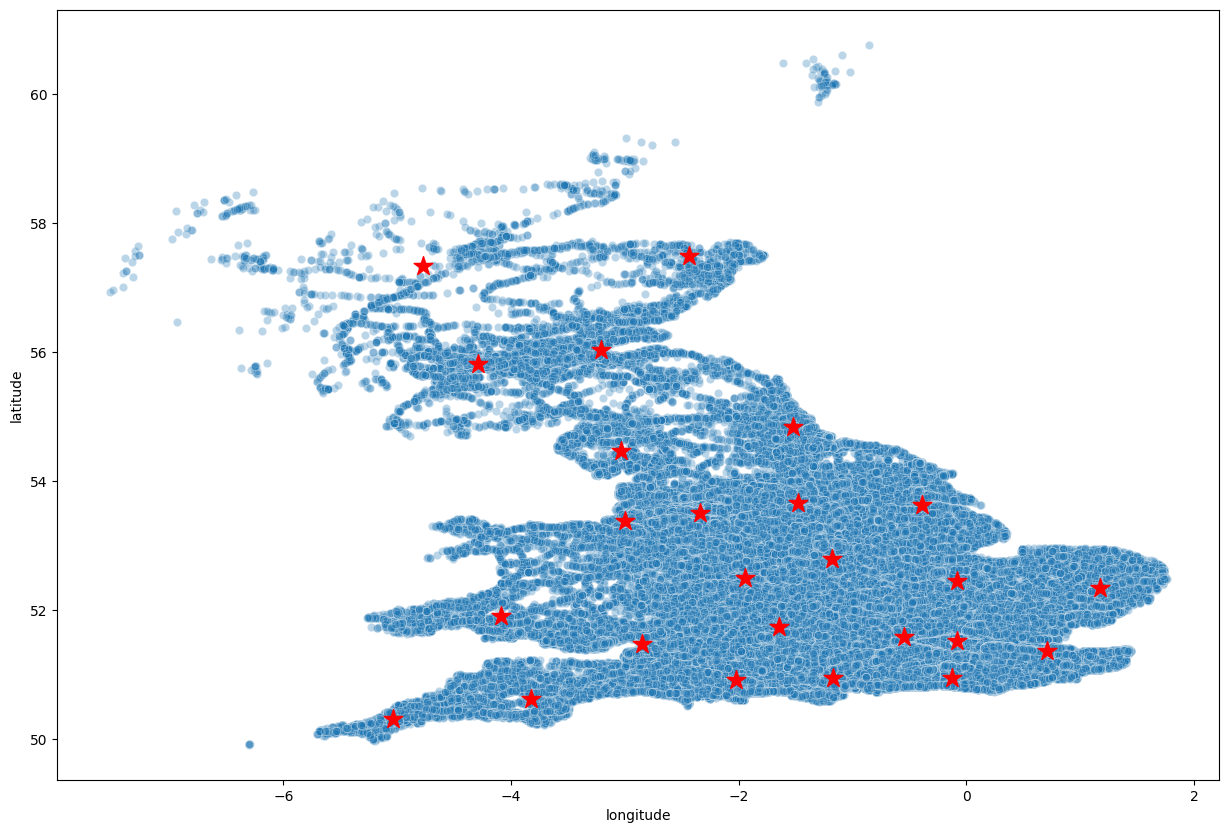

In [33]:
fig = plt.figure(figsize = (15, 10))
sns.scatterplot(data = acc_loc, x = acc_loc["longitude"], y = acc_loc["latitude"], alpha=0.3)
for cluster in set(cluster_labels_pred):
    centroid = kmeans.cluster_centers_[cluster]
    plt.scatter(centroid[0], centroid[1], marker = '*', s = 200, color = 'red')
plt.show()

In [34]:
cluster_labels_pred

array([23, 23, 23, ..., 20, 14, 14], dtype=int32)

In [35]:
inertia_25 = kmeans.inertia_
inertia_25

50957.495525405764

In [68]:
def number_of_clusters(x_scaled):
    inertia = []
    k_range = range(1, 35)
    for k in k_range:
        kmeans = KMeans(n_clusters = k, random_state = 42)
        kmeans.fit(x_scaled)
        inertia.append(kmeans.inertia_)

    plt.plot(k_range, inertia, 'bx-')
    plt.xlabel("Number of clusters")
    plt.ylabel("Inertia")
    plt.show()

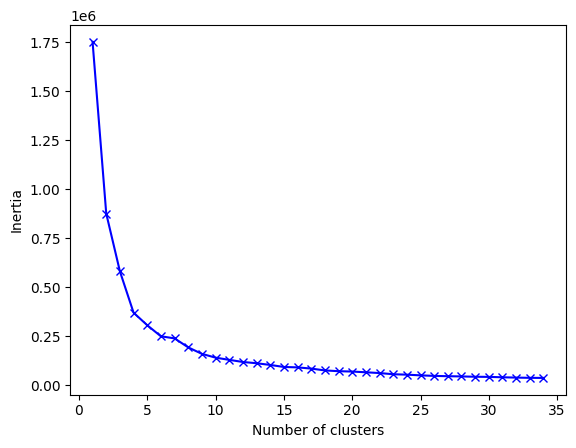

In [69]:
number_of_clusters(acc_loc)

In [38]:
speed_weather = accident_df[['weather_conditions', 'speed_limit']]
speed_weather

,weather_conditions,speed_limit
0,1,30
1,1,30
2,1,30
3,2,30
4,1,20
...,...,...
461347,1,30
461348,1,30
461349,1,60
461350,1,30


In [39]:
kmeans = KMeans(n_clusters = 6, random_state = 42)
kmeans.fit(speed_weather)

speed_weather_cluster = kmeans.predict(speed_weather)

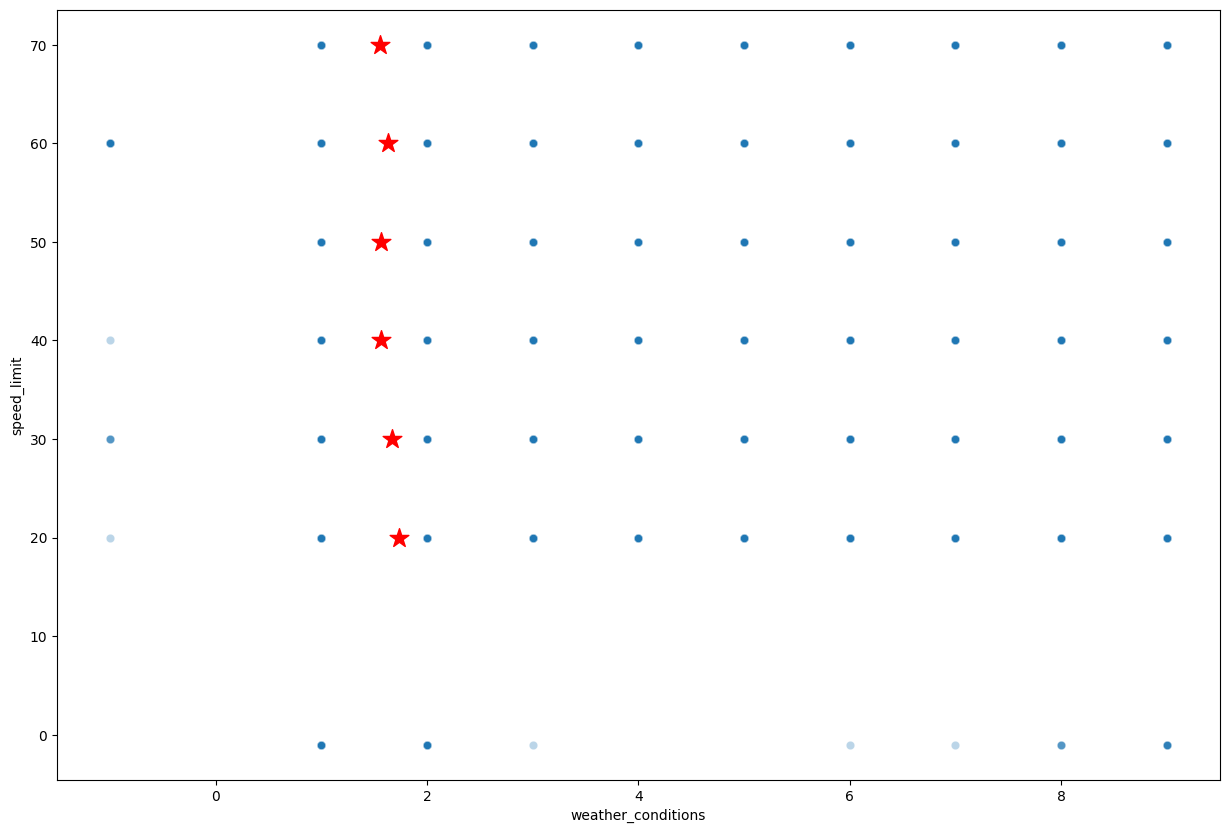

In [40]:
fig = plt.figure(figsize = (15, 10))
sns.scatterplot(data = speed_weather, x = speed_weather["weather_conditions"], y = speed_weather["speed_limit"], alpha=0.3)
for cluster in set(speed_weather_cluster):
    centroid = kmeans.cluster_centers_[cluster]
    plt.scatter(centroid[0], centroid[1], marker = '*', s = 200, color = 'red')
plt.show()

In [41]:
kmeans = KMeans(n_clusters = 12, random_state = 42)
kmeans.fit(speed_weather)

speed_weather_cluster = kmeans.predict(speed_weather)

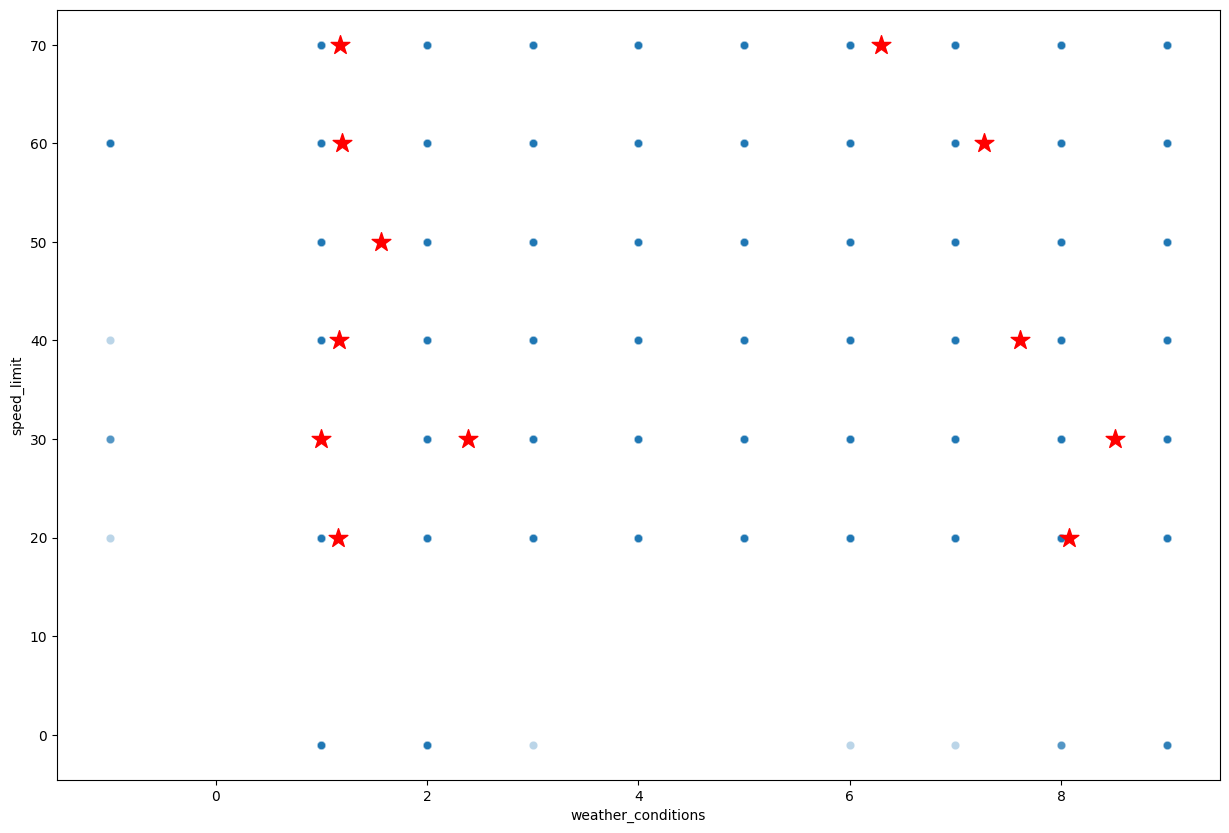

In [42]:
fig = plt.figure(figsize = (15, 10))
sns.scatterplot(data = speed_weather, x = speed_weather["weather_conditions"], y = speed_weather["speed_limit"], alpha=0.3)
for cluster in set(speed_weather_cluster):
    centroid = kmeans.cluster_centers_[cluster]
    plt.scatter(centroid[0], centroid[1], marker = '*', s = 200, color = 'red')
plt.show()

In [43]:
vehicle_df

,vehicle_index,accident_index,accident_year,accident_reference,vehicle_reference,vehicle_type,towing_and_articulation,vehicle_manoeuvre,vehicle_direction_from,vehicle_direction_to,...,journey_purpose_of_driver,sex_of_driver,age_of_driver,age_band_of_driver,engine_capacity_cc,propulsion_code,age_of_vehicle,generic_make_model,driver_imd_decile,driver_home_area_type
0,0,2017010001708,2017,010001708,1,9,0,18,1,5,...,6,1,24,5,1997,2,1,-1,-1,-1
1,1,2017010001708,2017,010001708,2,2,0,18,1,5,...,6,1,19,4,-1,-1,-1,-1,-1,-1
2,2,2017010009342,2017,010009342,1,9,0,18,5,1,...,6,1,33,6,1797,8,8,-1,9,1
3,3,2017010009342,2017,010009342,2,9,0,18,5,1,...,6,1,40,7,2204,2,12,-1,2,1
4,4,2017010009344,2017,010009344,1,9,0,18,3,7,...,6,3,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
849086,849086,2020991030297,2020,991030297,1,9,0,7,8,2,...,1,1,57,9,1968,2,2,AUDI A5,7,1
849087,849087,2020991030297,2020,991030297,2,5,0,16,6,2,...,5,1,38,7,1301,1,2,KTM 1290 SUPERDUKE,9,2
849088,849088,2020991030900,2020,991030900,1,9,0,7,8,2,...,6,2,68,10,1995,2,1,BMW X3,5,1
849089,849089,2020991030900,2020,991030900,2,1,0,18,6,2,...,6,1,76,11,-1,-1,-1,-1,9,1


In [44]:
cols = list(vehicle_df.columns)[5:24]
cols

['vehicle_type',
 'towing_and_articulation',
 'vehicle_manoeuvre',
 'vehicle_direction_from',
 'vehicle_direction_to',
 'vehicle_location_restricted_lane',
 'junction_location',
 'skidding_and_overturning',
 'hit_object_in_carriageway',
 'vehicle_leaving_carriageway',
 'hit_object_off_carriageway',
 'first_point_of_impact',
 'vehicle_left_hand_drive',
 'journey_purpose_of_driver',
 'sex_of_driver',
 'age_of_driver',
 'age_band_of_driver',
 'engine_capacity_cc',
 'propulsion_code']

In [45]:
vehicle_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 849091 entries, 0 to 849090
Data columns (total 28 columns):
 #   Column                            Non-Null Count   Dtype 
---  ------                            --------------   ----- 
 0   vehicle_index                     849091 non-null  int64 
 1   accident_index                    849091 non-null  object
 2   accident_year                     849091 non-null  int64 
 3   accident_reference                849091 non-null  object
 4   vehicle_reference                 849091 non-null  int64 
 5   vehicle_type                      849091 non-null  int64 
 6   towing_and_articulation           849091 non-null  int64 
 7   vehicle_manoeuvre                 849091 non-null  int64 
 8   vehicle_direction_from            849091 non-null  int64 
 9   vehicle_direction_to              849091 non-null  int64 
 10  vehicle_location_restricted_lane  849091 non-null  int64 
 11  junction_location                 849091 non-null  int64 
 12  sk

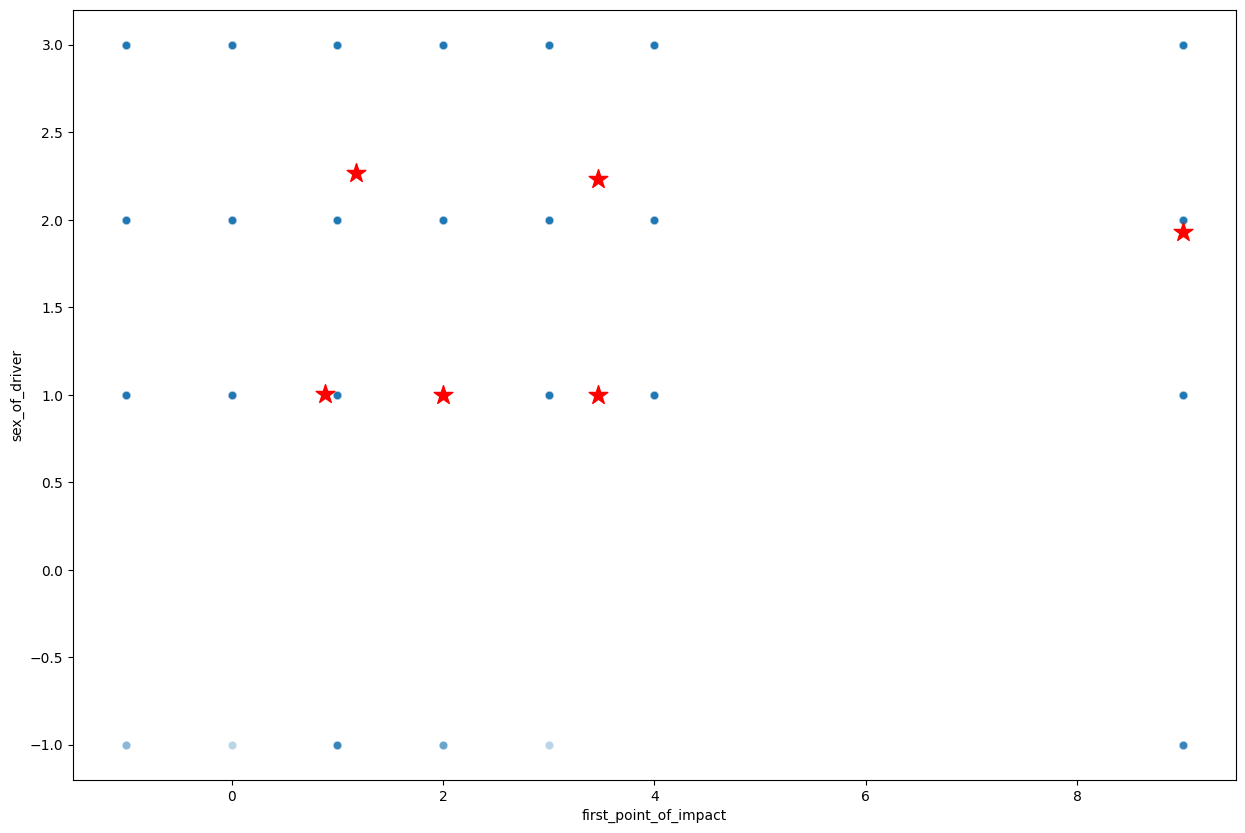

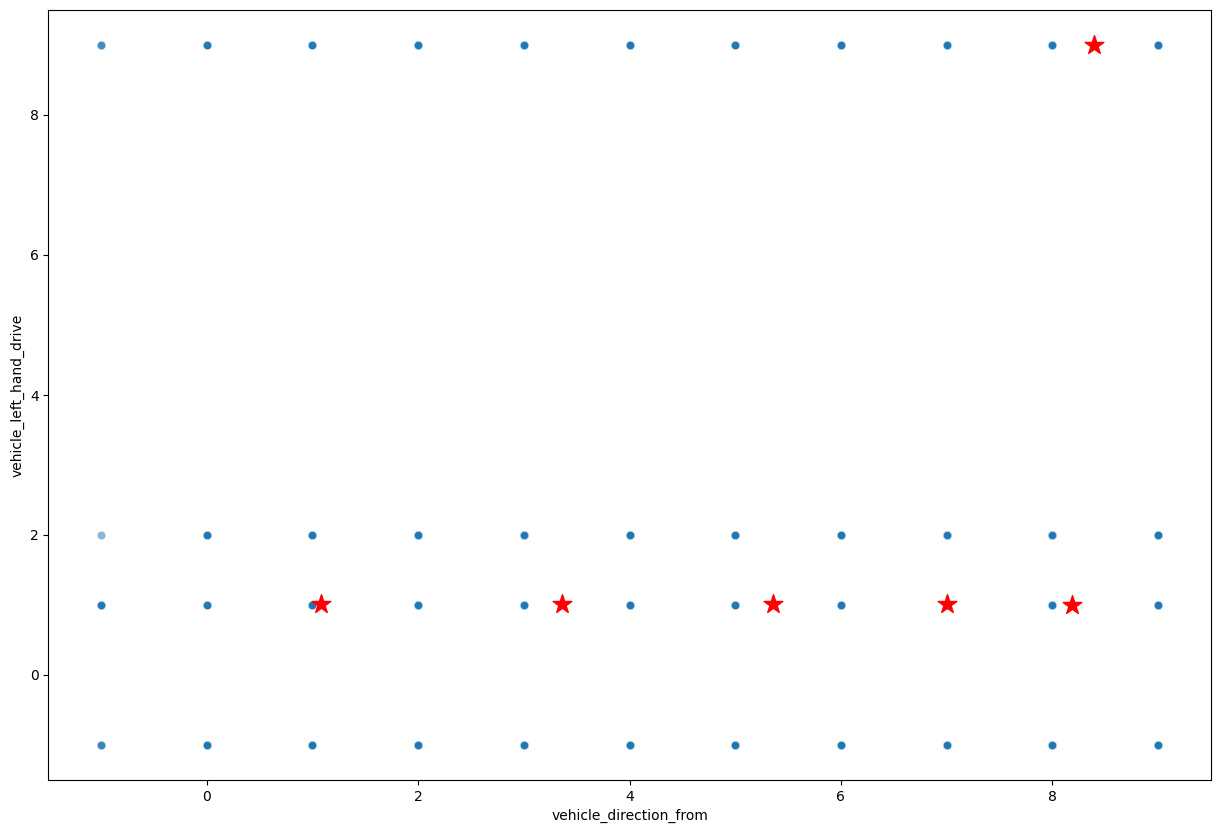

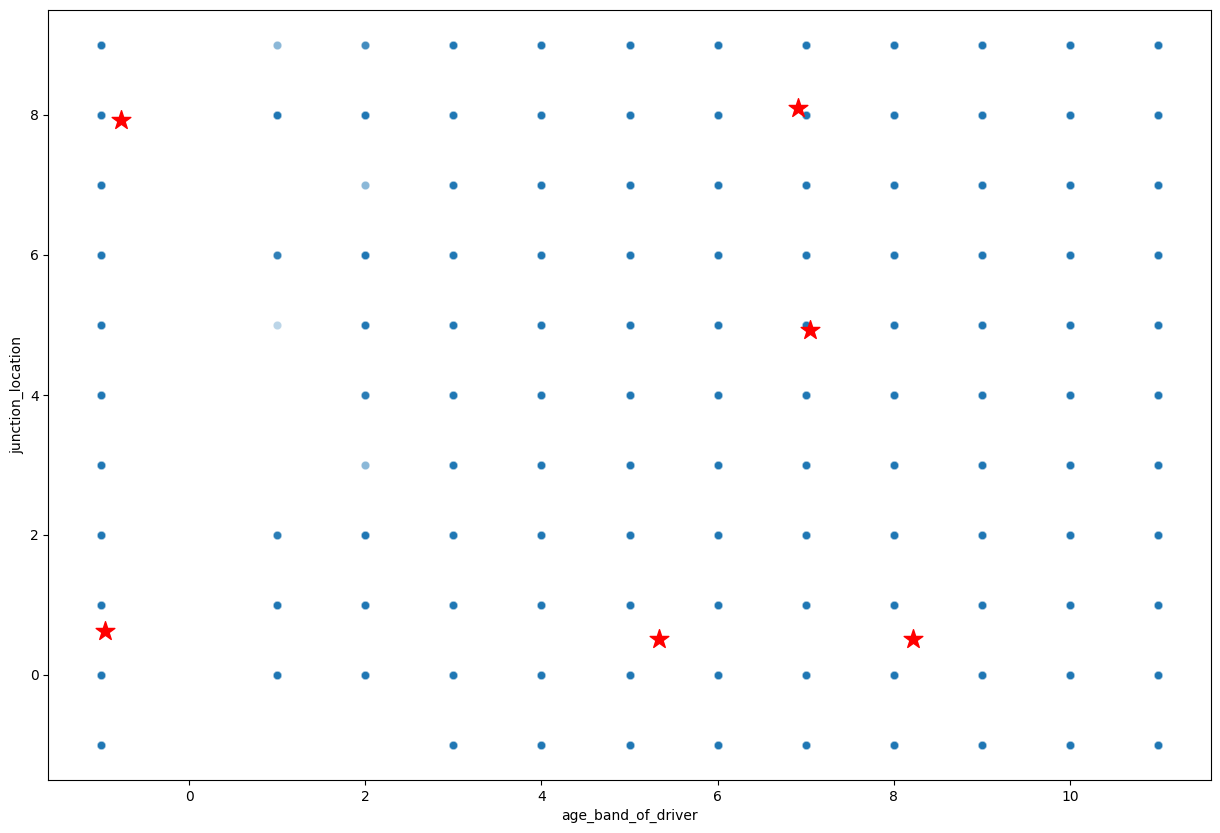

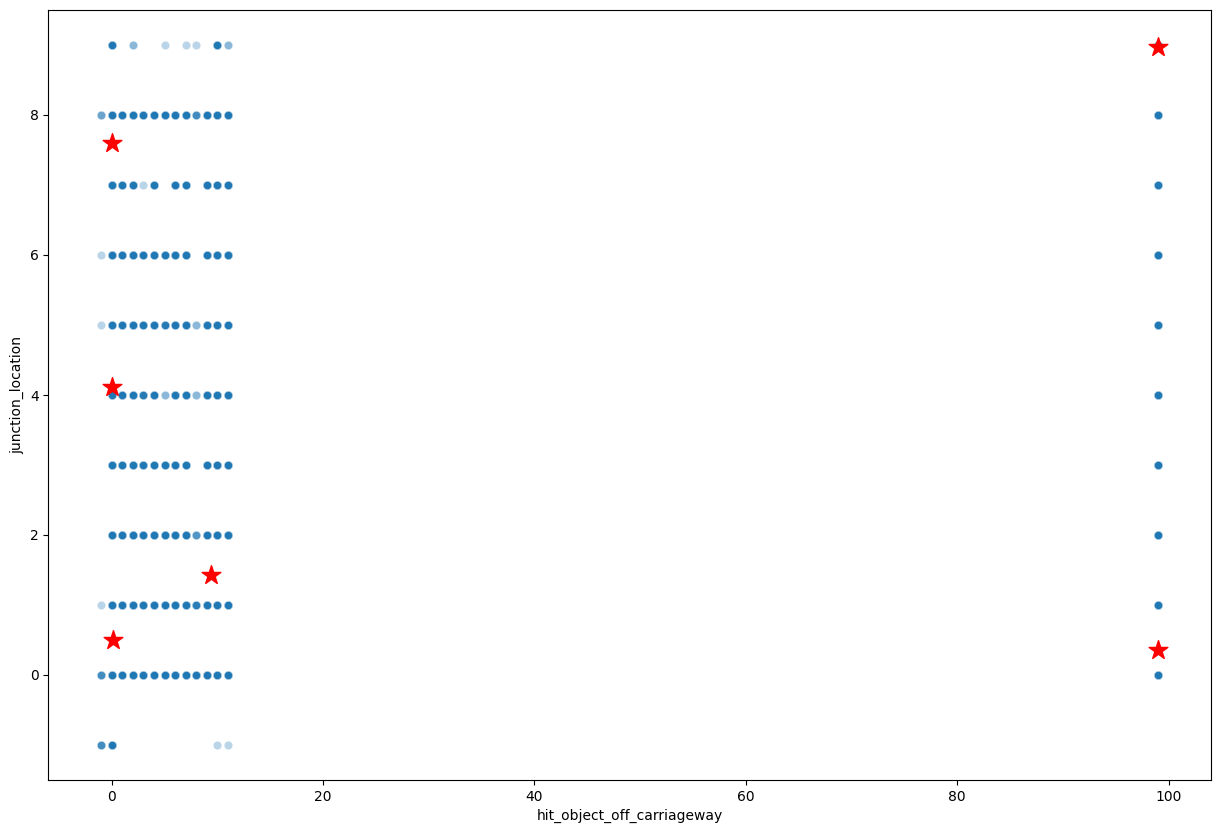

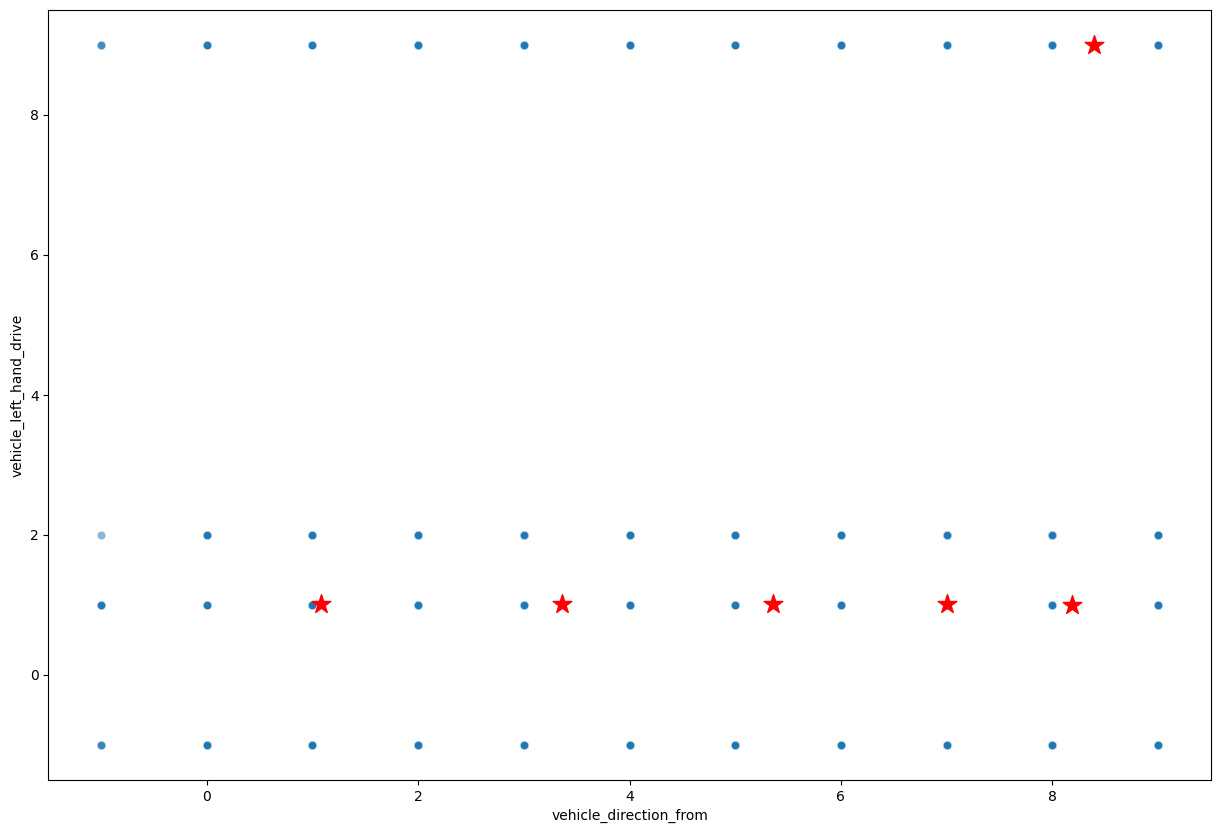

In [46]:
i = 0
while i < 5:
    ax = random.choice(cols)
    ay = random.choice(cols)
    if ax == ay:
        continue
    data = vehicle_df[[ax, ay]]
    kmeans = KMeans(n_clusters = 6, random_state = 42)
    kmeans.fit(data)
    data_cluster = kmeans.predict(data)
    fig = plt.figure(figsize = (15, 10))
    sns.scatterplot(data = data, x = data[ax], y = data[ay], alpha=0.3)
    for cluster in set(data_cluster):
        centroid = kmeans.cluster_centers_[cluster]
        plt.scatter(centroid[0], centroid[1], marker = '*', s = 200, color = 'red')
    plt.show()
    i += 1 

## WEEK 6 WORKSHOP

In [47]:
# rng = default_rng()
# idx = rng.choice(X.shape[0], size=20000, replace=False)
# x_small = X.iloc[idx]

In [48]:
# x_small

In [49]:
# clusters, k_means = kmeans_algorithm(X, 'coordinates', 25)

In [50]:
# fig = plt.figure(figsize = (15, 10))
# plt.scatter(x_small['longitude'], x_small['latitude'], marker='.', alpha=0.1)
# # centers = kmedoids.cluster_centers_
# # centers = k_means.cluster_centers_ 

# for cluster in set(clusters):
#     centroid = k_means.cluster_centers_[cluster]
#     plt.scatter(centroid[0], centroid[1], marker = '*', s = 200, color = 'red')
# plt.title('Geographic Clustering of Accidents kme')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.show()

# WEEK 7

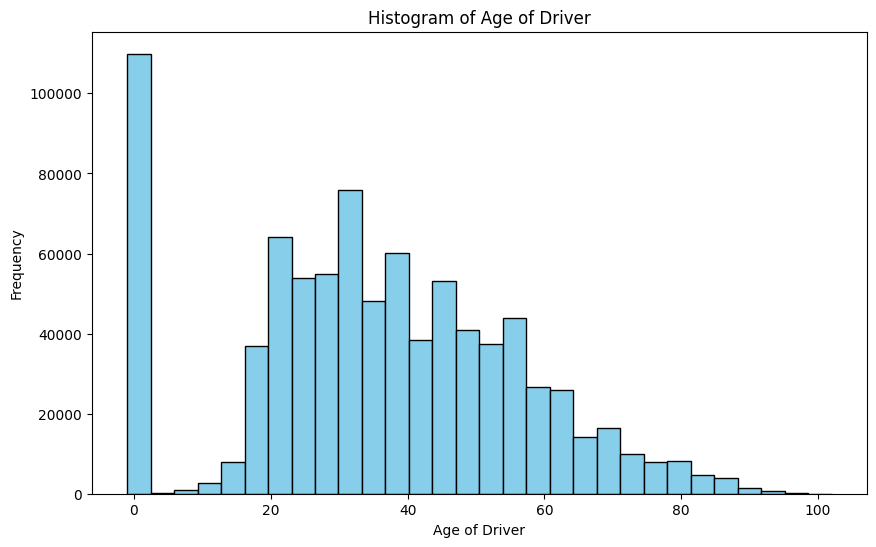

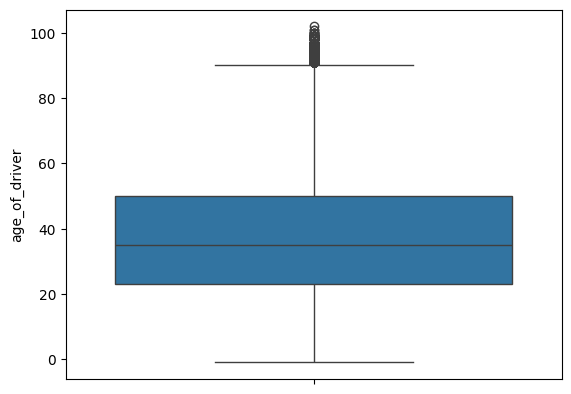

In [51]:
plt.figure(figsize=(10, 6))
plt.hist(vehicle_df['age_of_driver'].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Age of Driver')
plt.xlabel('Age of Driver')
plt.ylabel('Frequency')
plt.show()

sns.boxplot(vehicle_df['age_of_driver'])
plt.show()

In [52]:
vehicle_df.loc[vehicle_df['age_of_driver'] < 0]

,vehicle_index,accident_index,accident_year,accident_reference,vehicle_reference,vehicle_type,towing_and_articulation,vehicle_manoeuvre,vehicle_direction_from,vehicle_direction_to,...,journey_purpose_of_driver,sex_of_driver,age_of_driver,age_band_of_driver,engine_capacity_cc,propulsion_code,age_of_vehicle,generic_make_model,driver_imd_decile,driver_home_area_type
4,4,2017010009344,2017,010009344,1,9,0,18,3,7,...,6,3,-1,-1,-1,-1,-1,-1,-1,-1
15,15,2017010009354,2017,010009354,2,9,0,12,3,7,...,6,3,-1,-1,-1,-1,-1,-1,-1,-1
16,16,2017010009357,2017,010009357,1,9,0,18,4,8,...,6,3,-1,-1,-1,-1,-1,-1,-1,-1
19,19,2017010009360,2017,010009360,2,9,0,18,7,3,...,6,3,-1,-1,-1,-1,-1,-1,-1,-1
27,27,2017010009375,2017,010009375,1,3,0,2,0,0,...,6,3,-1,-1,108,1,5,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
848974,848974,2020991010956,2020,991010956,2,19,0,2,0,0,...,6,3,-1,-1,-1,-1,-1,-1,-1,-1
849018,849018,2020991012311,2020,991012311,2,19,0,2,0,0,...,6,3,-1,-1,2402,2,12,FORD TRANSIT,-1,-1
849056,849056,2020991016099,2020,991016099,2,9,0,2,0,0,...,6,3,-1,-1,-1,-1,-1,-1,-1,-1
849057,849057,2020991016099,2020,991016099,3,9,0,2,0,0,...,6,3,-1,-1,-1,-1,-1,-1,-1,-1


In [53]:
len(vehicle_df[vehicle_df['age_of_driver'] < 0]['age_of_driver'])

109890

In [54]:
vehicle_df[vehicle_df['age_of_driver'] < 17]['age_of_driver'].unique()

array([-1, 14, 16, 15, 12, 13,  9, 11, 10,  6,  8,  7,  3,  5,  4,  2,  1])

In [55]:
vehicle_df = vehicle_df[vehicle_df['age_of_driver'] >= 0]

In [56]:
len(vehicle_df[vehicle_df['age_of_driver'] < 0]['age_of_driver'])

0

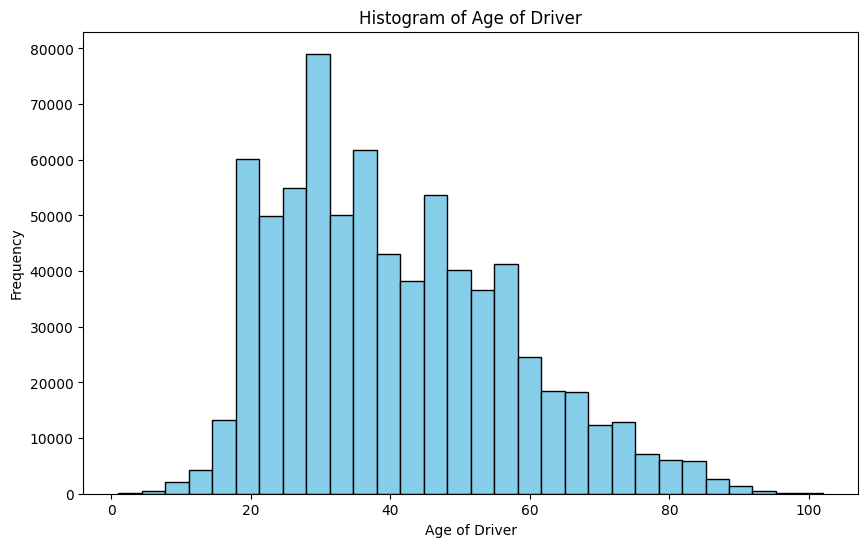

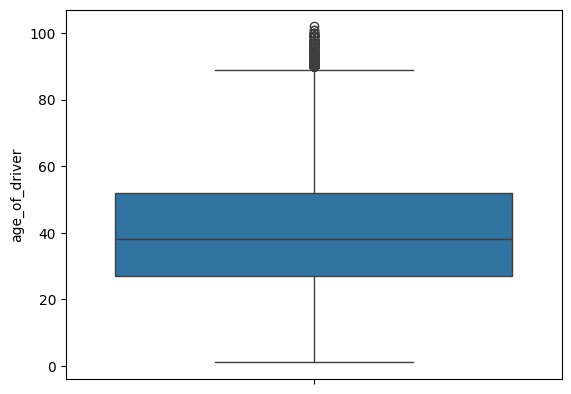

In [57]:
plt.figure(figsize=(10, 6))
plt.hist(vehicle_df['age_of_driver'].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Age of Driver')
plt.xlabel('Age of Driver')
plt.ylabel('Frequency')
plt.show()

sns.boxplot(vehicle_df['age_of_driver'])
plt.show()

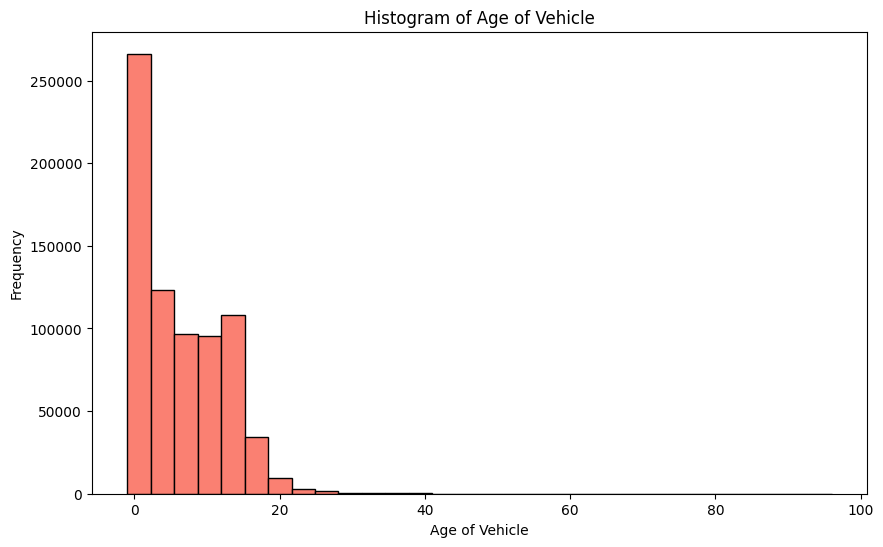

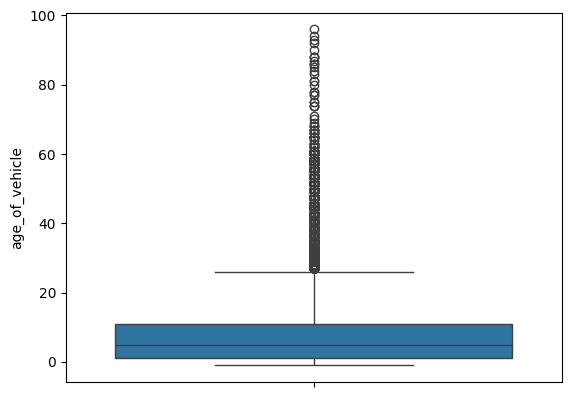

In [58]:
# Plot histogram for age_of_vehicle
plt.figure(figsize=(10, 6))
plt.hist(vehicle_df['age_of_vehicle'].dropna(), bins=30, color='salmon', edgecolor='black')
plt.title('Histogram of Age of Vehicle')
plt.xlabel('Age of Vehicle')
plt.ylabel('Frequency')
plt.show()

sns.boxplot(vehicle_df['age_of_vehicle'])
plt.show()

In [59]:
vehicle_df = vehicle_df[vehicle_df['age_of_vehicle'] >= 0]

In [60]:
vehicle_df[vehicle_df['age_of_vehicle'] < 0]

,vehicle_index,accident_index,accident_year,accident_reference,vehicle_reference,vehicle_type,towing_and_articulation,vehicle_manoeuvre,vehicle_direction_from,vehicle_direction_to,...,journey_purpose_of_driver,sex_of_driver,age_of_driver,age_band_of_driver,engine_capacity_cc,propulsion_code,age_of_vehicle,generic_make_model,driver_imd_decile,driver_home_area_type


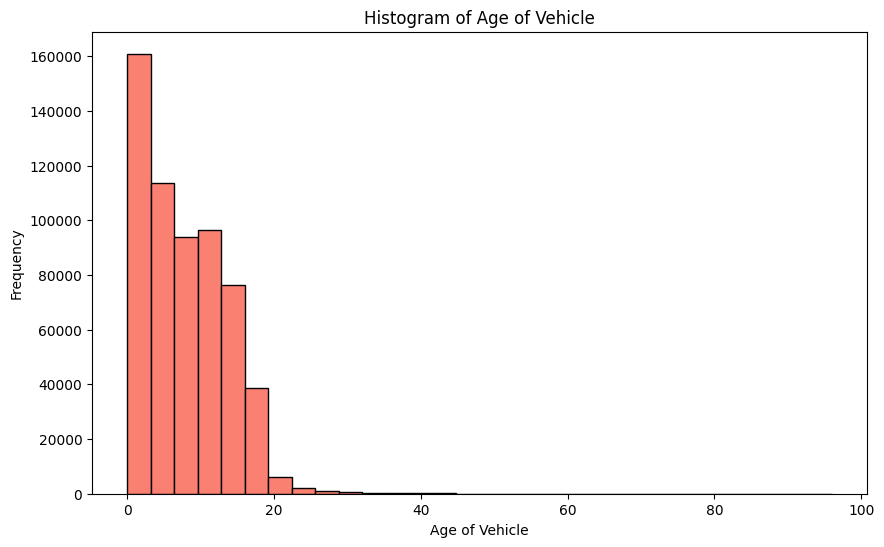

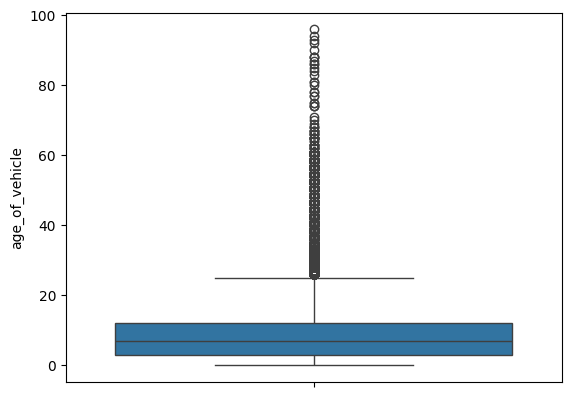

In [61]:
# Plot histogram for age_of_vehicle
plt.figure(figsize=(10, 6))
plt.hist(vehicle_df['age_of_vehicle'].dropna(), bins=30, color='salmon', edgecolor='black')
plt.title('Histogram of Age of Vehicle')
plt.xlabel('Age of Vehicle')
plt.ylabel('Frequency')
plt.show()

sns.boxplot(vehicle_df['age_of_vehicle'])
plt.show()

In [62]:
def inter_quatile(data):
    q75, q25 = np.percentile(data, [75, 25])
    iqr = q75 - q25
    print('Inter quatile range = ', iqr)
    print(q25-1.5*iqr, q75+1.5*iqr)
    print(q25-3*iqr, q75+3*iqr)

In [63]:
inter_quatile(vehicle_df['age_of_driver'])

Inter quatile range =  24.0
-8.0 88.0
-44.0 124.0


In [64]:
inter_quatile(vehicle_df['age_of_vehicle'])

Inter quatile range =  9.0
-10.5 25.5
-24.0 39.0


In [65]:
def grubbs_test(data):
    """
    Compute Grubbs' test statistic G and return the index of the row with the maximum G value.

    Parameters:
    - data: A list or array-like object containing the dataset.

    Returns:
    - index: Index of the row that results in the maximum G value.
    """
    # Convert data to numpy array
    data = np.array(data)
    
    # Calculate sample mean and standard deviation
    mean = np.mean(data)
    std_dev = np.std(data)
    
    # Calculate Grubbs' test statistic G
    G = np.abs(data - mean) / std_dev
    # Find the index of the row with the maximum G value
    index = np.argmax(G)
    return index

In [66]:
index = grubbs_test(vehicle_df['age_of_driver'])

In [67]:
index

422289